In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

from tqdm import trange
from utils import *
from unet import *
from attention import *
from time_embedding import *
from vae import *
from ddpm import *


In [ ]:
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 26421880/26421880 [00:02<00:00, 11623384.94it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 215407.46it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3860437.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20882279.49it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# def data_collate(batch):
#     X, y = zip(*batch)
#     ddpm = DDPM(0, 1, 5)
#     X = torch.stack(X, dim=0)
#     y = torch.tensor(y)
#     (X, t), noise = ddpm.schedule(X)
#     return (X, t, y), noise


In [ ]:
train_dataloader, test_dataloader, classes = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [ ]:
unet = UNET(10, 1, 1, (32,64,128,256)).to(device)

In [ ]:
print(sum([p.numel() for p in unet.parameters()]))

15938144


In [ ]:
lr = 1e-3
epochs = 25
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))


In [ ]:
import matplotlib.pyplot as plt

def show_image(image, msg=None):
    single_image = image[0].detach().cpu().permute(1, 2, 0).numpy()
    plt.imshow(single_image, cmap="gray")
    plt.title(f'{msg}Image')
    plt.axis('off')
    plt.show()


In [ ]:
class DDPM:
    def __init__(self, beta_min, beta_max, n_steps, device):
        init_attr(self, locals())
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1 - self.beta
        self.alpha_bar = self.alpha.cumprod(dim=0).to(self.device)
        self.sigma = self.beta.sqrt()

    def schedule(self, x):
        t = torch.randint(0, self.n_steps, (len(x),), dtype=torch.long, device=self.device)
        noise = torch.randn_like(x).to(self.device)
        alpha_bar_t = self.alpha_bar[t].reshape(-1, 1, 1, 1)
        mean = alpha_bar_t.sqrt()*x
        variance = (1 - alpha_bar_t).sqrt()*noise
        x = mean + variance
        return x, t, noise

    # @torch.inference_mode()
    # def sample(self, model, sz, )
    @torch.no_grad()
    def sample(self, model, sz, c):
        device = self.device
        xt = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            c = c.to(device)
            t_batch = torch.full((xt.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(xt.shape) if t > 0 else torch.zeros(xt.shape)).to(device)
            ᾱ_t1 = self.alpha_bar[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.alpha_bar[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = model(xt, t_batch, c)
            if t == 0: show_image(noise_pred)
            x_0_hat = ((xt - b̄_t.sqrt() * noise_pred)/self.alpha_bar[t].sqrt()).clamp(-1,1)
            xt = x_0_hat * ᾱ_t1.sqrt()*(1-self.alpha[t])/b̄_t + xt * self.alpha[t].sqrt()*b̄_t1/b̄_t + self.sigma[t]*z
            preds.append(xt.cpu())
        return preds

    # @torch.no_grad()
    # def sample(model, sz):
    #     device = self.device
    #     ps = next(model.parameters())
    #     x_t = torch.randn(sz).to(device)
    #     preds = []
    #     for t in reversed(range(n_steps)):
    #         t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
    #         z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
    #         ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
    #         b̄_t = 1-alphabar[t]
    #         b̄_t1 = 1-ᾱ_t1
    #         noise = model((x_t, t_batch))
    #         x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
    #         x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
    #         preds.append(x_t.float().cpu())
    #     return preds

In [ ]:
ddpm = DDPM(0.0001, 0.02, 1000, device)

In [ ]:
# for X, y in train_dataloader:
#     X = X.to(device)
#     xt, t, noise = ddpm.schedule(X)
#     print(xt.shape)
#     show_image(xt, "Noised ")
#     print(noise.shape)
#     show_image(noise, "Actual Noise ")
#     print(t.shape)
#     break


In [ ]:
def train(model, epochs=9, print_freq=1000):
    model.to(device)
    for epoch in trange(epochs):
        model.train()
        total_loss = 0
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            xt, t, noise = ddpm.schedule(X)
            pred = model(xt, t, y)
            loss = loss_fn(pred, noise)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % print_freq == 0:
                # show_image(xt)
                print(f"Epoch: {epoch}, Batch: {batch}, Loss: {loss.item()}")

        schedular.step()
        print(f"Epoch: {epoch} = Loss: {total_loss/len(train_dataloader)}")
        torch.save(unet.state_dict(), "./Saved Models/unet_model.pth")


In [ ]:
torch.save(unet.state_dict(), "./Saved Models/unet_model.pth")

In [ ]:
train(unet)

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0, Batch: 0, Loss: 1.0629916191101074


100%|██████████| 1/1 [06:48<00:00, 408.36s/it]

Epoch: 0 = Loss: 0.12227272962940845


In [ ]:
train(unet)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 0, Batch: 0, Loss: 0.04540402069687843
Epoch: 0 = Loss: 0.0448182977930601


 11%|█         | 1/9 [06:48<54:30, 408.81s/it]

Epoch: 1, Batch: 0, Loss: 0.04882441461086273
Epoch: 1 = Loss: 0.034834669307192


 22%|██▏       | 2/9 [13:37<47:40, 408.66s/it]

Epoch: 2, Batch: 0, Loss: 0.027844727039337158
Epoch: 2 = Loss: 0.02893354755236523


 33%|███▎      | 3/9 [20:25<40:51, 408.52s/it]

Epoch: 3, Batch: 0, Loss: 0.039535582065582275
Epoch: 3 = Loss: 0.025343207204575415


 44%|████▍     | 4/9 [27:14<34:02, 408.45s/it]

Epoch: 4, Batch: 0, Loss: 0.01927243173122406
Epoch: 4 = Loss: 0.02348162043990611


 56%|█████▌    | 5/9 [34:02<27:13, 408.33s/it]

Epoch: 5, Batch: 0, Loss: 0.01720987632870674
Epoch: 5 = Loss: 0.02193930395531343


 67%|██████▋   | 6/9 [40:50<20:24, 408.23s/it]

Epoch: 6, Batch: 0, Loss: 0.012600891292095184
Epoch: 6 = Loss: 0.020743767211614833


 78%|███████▊  | 7/9 [47:38<13:36, 408.21s/it]

Epoch: 7, Batch: 0, Loss: 0.014024695381522179
Epoch: 7 = Loss: 0.020491265934079822


 89%|████████▉ | 8/9 [54:26<06:48, 408.16s/it]

Epoch: 8, Batch: 0, Loss: 0.014572408981621265
Epoch: 8 = Loss: 0.019435246034201655


100%|██████████| 9/9 [1:01:14<00:00, 408.33s/it]


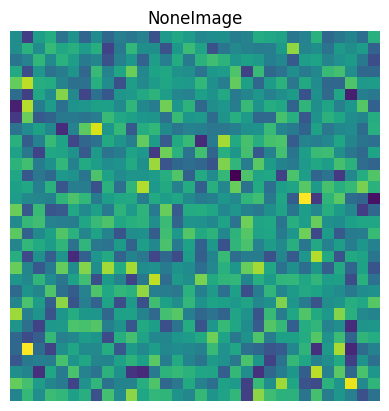

In [ ]:
sample = ddpm.sample(unet, (2, 1, 32, 32), torch.tensor(5))

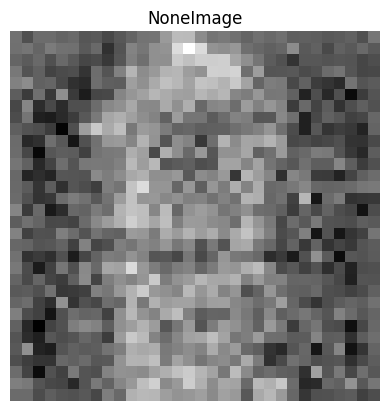

In [ ]:
show_image(sample[-1])

In [ ]:
# def sample():
#     model.eval()
#     with torch.inference_mode():
#         x = torch.randn